In [1]:
# from deepiforest.algorithms.dif import DIF

import sys
import os
sys.path.append(os.path.abspath("../../deep-i-forest/deep-iforest"))
from algorithms.dif import DIF

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

In [1]:
import matplotlib
print(matplotlib.__file__)


/opt/miniconda3/envs/deepiforest/lib/python3.9/site-packages/matplotlib/__init__.py


In [2]:
data = pd.read_csv('vacuum_sensor_data.csv', sep = ';')
data

,momento,1-0005,5-0005,1-_006,5-_006,1-_007,5-_007,1-_008,5-_008,1-_010,...,1-_098,5-_098,1-_099,5-_099,1-0112,5-0112,1-0116,5-0116,1-0109,5-0109
0,1,-588.88,-580.21,-590.50,-582.25,-593.51,-585.46,-595.51,-587.47,-575.36,...,-588.17,-581.42,-594.26,-586.26,-589.46,-581.75,-592.92,-586.26,-593.93,-586.30
1,2,-588.38,-579.71,-590.80,-582.46,-593.80,-585.67,-595.55,-587.59,-574.11,...,-588.34,-581.63,-594.51,-586.26,-589.29,-581.58,-592.80,-586.26,-594.13,-586.51
2,3,-584.41,-575.74,-585.83,-577.66,-591.38,-583.21,-589.84,-578.04,-563.34,...,-588.17,-581.33,-592.88,-584.34,-588.50,-580.62,-590.21,-583.75,-593.68,-585.84
3,4,-573.73,-565.27,-570.31,-562.81,-578.91,-571.24,-578.61,-565.90,-555.00,...,-584.79,-576.87,-580.62,-568.15,-586.96,-578.75,-578.66,-571.19,-590.88,-582.63
4,5,-567.27,-558.55,-562.26,-554.55,-570.69,-562.93,-567.18,-557.51,-545.99,...,-579.11,-570.99,-572.11,-560.43,-583.45,-574.91,-571.06,-563.56,-587.38,-578.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,637,-237.18,-253.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
637,638,-237.10,-253.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
638,639,-237.14,-253.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
639,640,-237.10,-253.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#rename column to have consistent naming 
import re

def clean_column(col):
    if col == 'momento':
        return col
    match = re.match(r"(\d)-_?(\d+)", col)
    if match:
        sensor, comp = match.groups()
        return f"{sensor}-{int(comp):04d}"
    return col  # fallback in case format is already correct

# Apply renaming
data.columns = [clean_column(col) for col in data.columns]

In [4]:
# drop rows(seconds) where data from any sensor is missing
data=data.dropna(axis=0)

In [5]:
data.shape

(533, 77)

In [6]:
# narrow the time window
window = (data['momento'] >= 50) & (data['momento'] <= 200)


In [7]:
#split columns into train and validation
defective_columns = ['1-0116', '5-0116', '1-0109', '5-0109']
normal_control_columns = ['1-0008', '5-0008', '1-0064', '5-0064']
validation_columns = defective_columns + normal_control_columns

df_validation = data[['momento'] + validation_columns]
train_columns = [col for col in data.columns if col not in validation_columns]
df_train = data[train_columns]

df_train_windowed = df_train.loc[window]
df_validation_windowed = df_validation.loc[window]

In [8]:
# Parameters
window_size = 10
step_size = 5
sample_rate = 1  # Sample rate of 1 means we use all points

# Create sliding windows
def create_sliding_windows(series, window_size, step):
    windows = []
    for start in range(0, len(series) - window_size + 1, step):
        window = series[start:start + window_size]
        if len(window) == window_size:
            windows.append(window)
    return np.array(windows)


In [11]:
#Use all available training columns to build a model that generalizes "normal" behavior.
#Create training windows from all training columns

train_windows_all = []

for col in df_train_windowed.columns:
    series = df_train_windowed[col].dropna().values
    if len(series) < window_size:
        continue
    windows = create_sliding_windows(series, window_size, step_size)
    train_windows_all.append(windows)

if not train_windows_all:
    raise ValueError("No valid training windows found in training set.")

train_windows_combined = np.vstack(train_windows_all)


In [15]:
# Update detect_anomalies() to use precomputed training windows

def detect_anomalies(precomputed_train_windows, validation_series, window_size, step_size):
    validation_windows = create_sliding_windows(validation_series.values, window_size, step_size)

    if len(precomputed_train_windows) == 0 or len(validation_windows) == 0:
        return []

    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(precomputed_train_windows)
    val_scaled = scaler.transform(validation_windows)

    network_params = {
    'n_hidden': [100, 50],
    'n_emb': 12,
    'skip_connection': None,
    'dropout': 0.1,
    'activation': 'relu',
    'be_size': 20
    }

    model = DIF(device='cpu', **network_params)

    model.fit(train_scaled)

    scores = model.decision_function(val_scaled)
    return scores


In [16]:
def plot_anomaly_scores_with_raw(scores, column_name, raw_series, start_second=50, step_size=5, window_size=10, ymin=0.2, ymax=0.5):
    print(f"Plotting anomaly scores and raw signal for {column_name}...")
    if scores is None or len(scores) == 0 or raw_series is None or raw_series.empty:
        print(f"Missing data for {column_name}, skipping.")
        return

    # X-axis for scores: center of each window in seconds
    window_indices = np.arange(len(scores))
    time_scores = start_second + window_indices * step_size + window_size // 2

    # X-axis for raw values: time in seconds
    time_raw = raw_series.index.values  # Assuming index contains time in seconds
    if isinstance(time_raw[0], pd.Timestamp):
        time_raw = (raw_series.index - raw_series.index[0]).total_seconds() + start_second

    fig, ax1 = plt.subplots(figsize=(12, 4))

    # Plot anomaly scores
    ax1.plot(time_scores, scores, marker='o', linestyle='-', color='darkred', label='Anomaly Score')
    ax1.set_ylabel("Anomaly Score", color='darkred')
    ax1.set_ylim(ymin, ymax)
    ax1.tick_params(axis='y', labelcolor='darkred')

    # Twin Y-axis for raw signal
    ax2 = ax1.twinx()
    ax2.plot(time_raw, raw_series.values, color='steelblue', alpha=0.7, label='Raw Signal')
    ax2.set_ylabel("Raw Signal Value", color='steelblue')
    ax2.set_ylim(-560, -330)  # ✅ Fixed raw signal Y-axis scale
    ax2.tick_params(axis='y', labelcolor='steelblue')

    ax1.set_xlabel("Time (s)")
    plt.title(f"Anomaly Scores and Raw Signal for {column_name}")
    fig.tight_layout()
    plt.grid(True)
    plt.show()


Starting anomaly detection...
Processing column: 1-0116
network additional parameters: {'n_hidden': [500, 100], 'n_emb': 20, 'be_size': 50, 'skip_connection': None, 'dropout': 0.1, 'activation': 'relu'}
  -> Got 29 scores for column 1-0116
Plotting anomaly scores and raw signal for 1-0116...


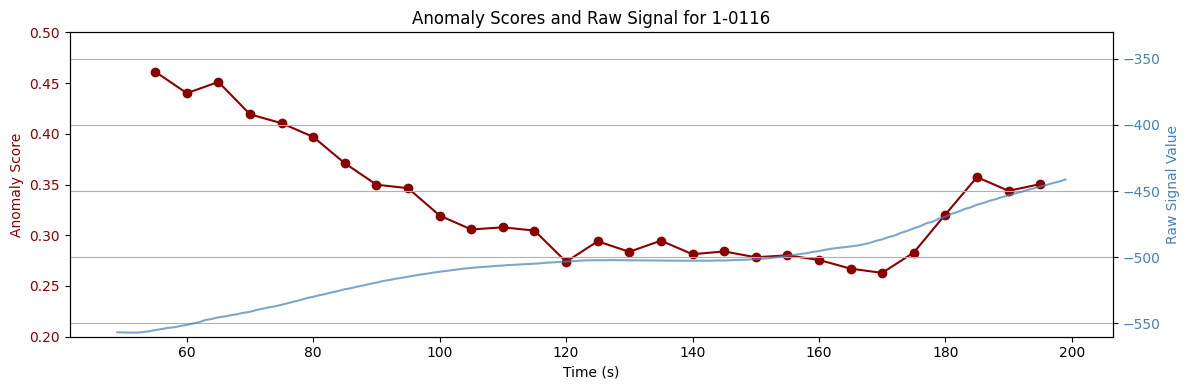

Processing column: 5-0116
network additional parameters: {'n_hidden': [500, 100], 'n_emb': 20, 'be_size': 50, 'skip_connection': None, 'dropout': 0.1, 'activation': 'relu'}
  -> Got 29 scores for column 5-0116
Plotting anomaly scores and raw signal for 5-0116...


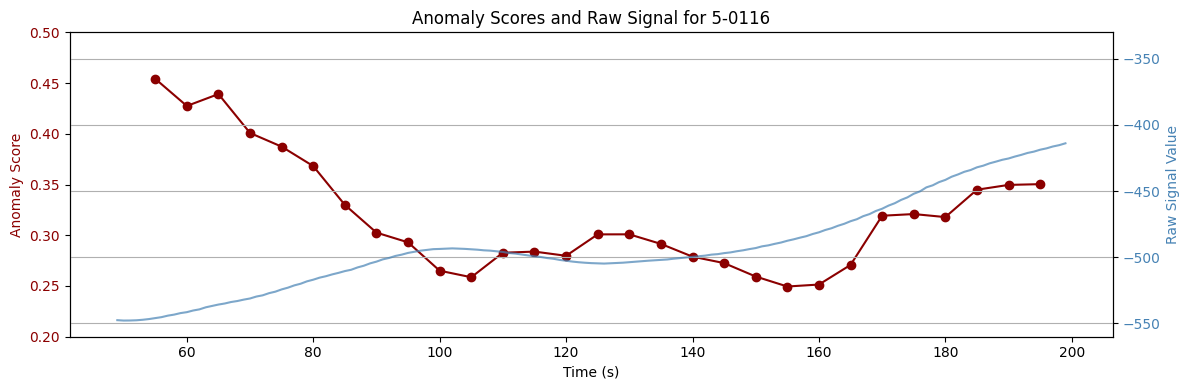

Processing column: 1-0109
network additional parameters: {'n_hidden': [500, 100], 'n_emb': 20, 'be_size': 50, 'skip_connection': None, 'dropout': 0.1, 'activation': 'relu'}
  -> Got 29 scores for column 1-0109
Plotting anomaly scores and raw signal for 1-0109...


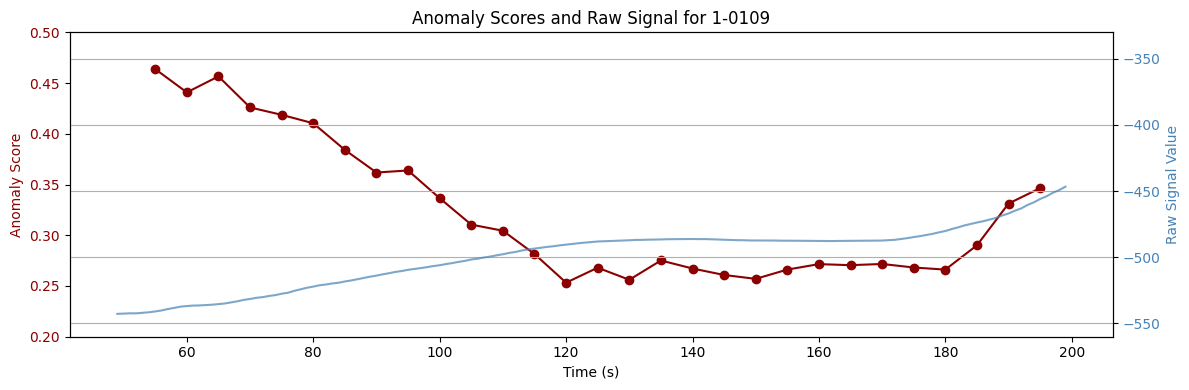

Processing column: 5-0109
network additional parameters: {'n_hidden': [500, 100], 'n_emb': 20, 'be_size': 50, 'skip_connection': None, 'dropout': 0.1, 'activation': 'relu'}
  -> Got 29 scores for column 5-0109
Plotting anomaly scores and raw signal for 5-0109...


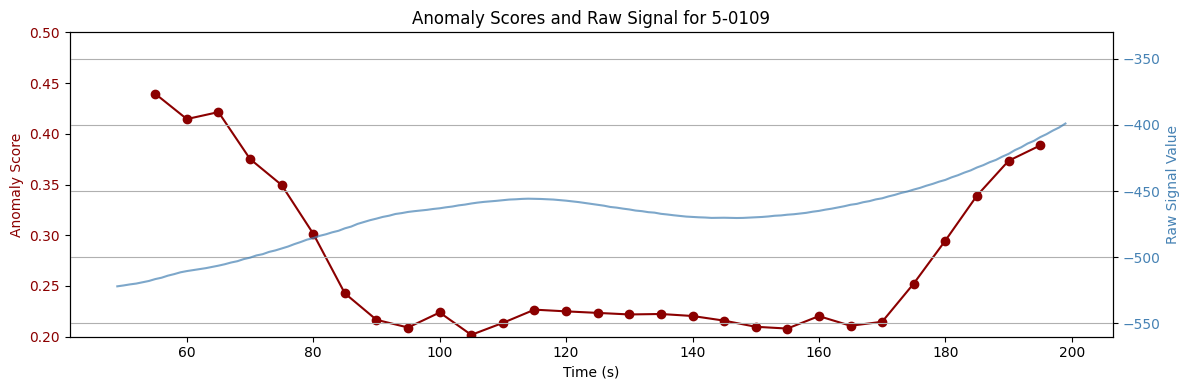

Processing column: 1-0008
network additional parameters: {'n_hidden': [500, 100], 'n_emb': 20, 'be_size': 50, 'skip_connection': None, 'dropout': 0.1, 'activation': 'relu'}
  -> Got 29 scores for column 1-0008
Plotting anomaly scores and raw signal for 1-0008...


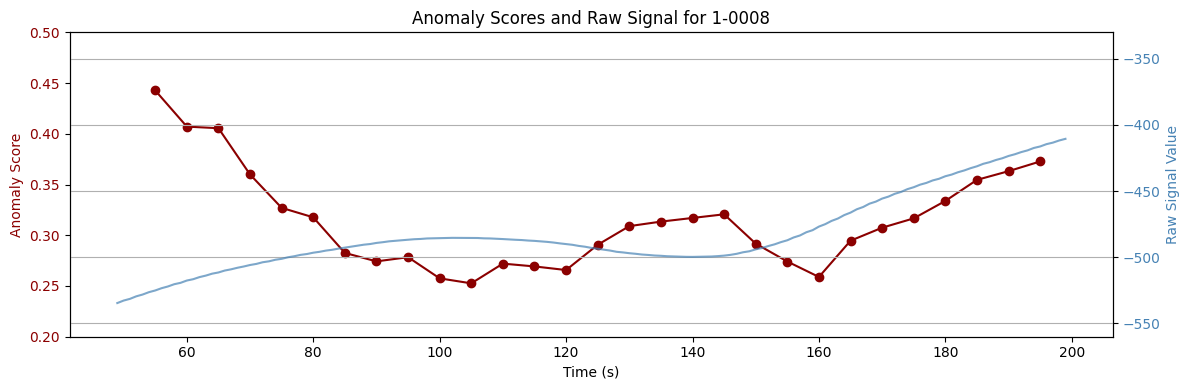

Processing column: 5-0008
network additional parameters: {'n_hidden': [500, 100], 'n_emb': 20, 'be_size': 50, 'skip_connection': None, 'dropout': 0.1, 'activation': 'relu'}
  -> Got 29 scores for column 5-0008
Plotting anomaly scores and raw signal for 5-0008...


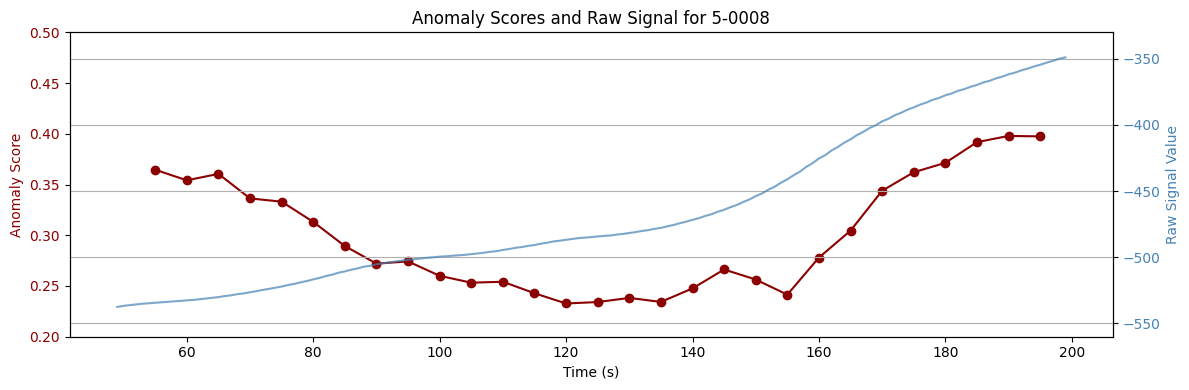

Processing column: 1-0064
network additional parameters: {'n_hidden': [500, 100], 'n_emb': 20, 'be_size': 50, 'skip_connection': None, 'dropout': 0.1, 'activation': 'relu'}
  -> Got 29 scores for column 1-0064
Plotting anomaly scores and raw signal for 1-0064...


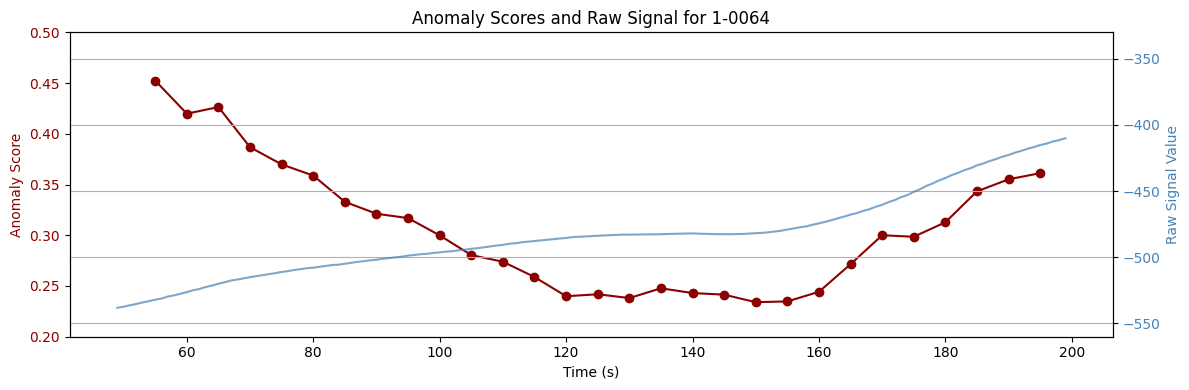

Processing column: 5-0064
network additional parameters: {'n_hidden': [500, 100], 'n_emb': 20, 'be_size': 50, 'skip_connection': None, 'dropout': 0.1, 'activation': 'relu'}
  -> Got 29 scores for column 5-0064
Plotting anomaly scores and raw signal for 5-0064...


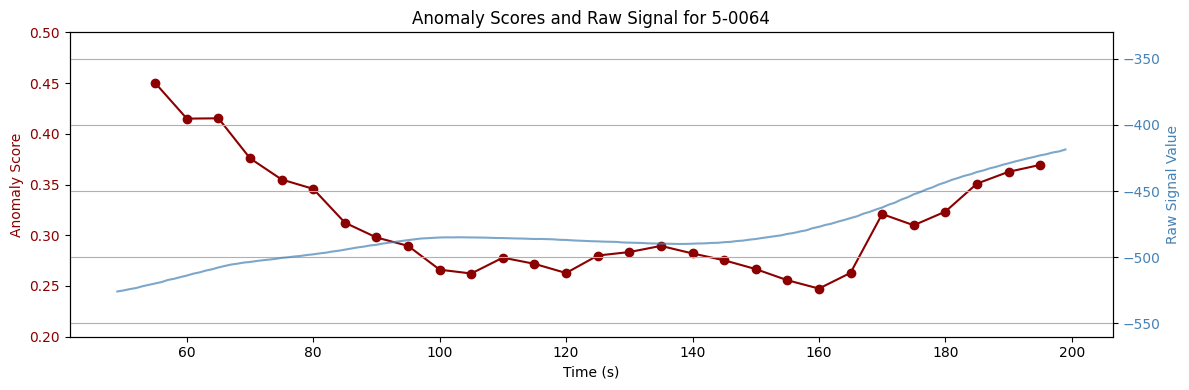

In [17]:
print("Starting anomaly detection...")

for col in validation_columns:
    print(f"Processing column: {col}")

    if col not in df_validation_windowed.columns:
        print(f"  -> Column {col} not found. Skipping.")
        continue

    validation_series = df_validation_windowed[col].dropna()

    if len(validation_series) < window_size:
        print(f"  -> Not enough data. Skipping.")
        continue

    scores = detect_anomalies(train_windows_combined, validation_series, window_size, step_size)
    print(f"  -> Got {len(scores)} scores for column {col}")

    # ✅ This line must be inside the loop
    raw_series = df_validation_windowed[col]
    plot_anomaly_scores_with_raw(scores, col, raw_series, start_second=50, step_size=step_size, window_size=window_size)
